# Processing data using Spark Dataframe with Pyspark

View spark version

In [1]:
spark.version

'2.1.1'

Load Spark SQL functions, for example: count, avg, explode etc.

In [2]:
from pyspark.sql.functions import *

Location of movies dataset. You can download the dataset from here. Here we are using latest-small dataset.

In [3]:
home_dir = "/user/cloudera/Downloads/datasets/movie-lens"

Create a dataframe on movies.csv file

In [4]:
movies = spark.read.format("csv")\
.options(header = True, inferSchema = True)\
.load(home_dir + "/movies")\
.persist() # Keep the dataframe in memory for faster processing 

Show schema of movies dataframe

In [5]:
movies.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



Display a few sample view from movies Dataframe

In [6]:
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



Create ratings Dataframe using ratings.csv file

In [7]:
ratings = spark.read.format("csv")\
.options(header = True, inferSchema = True)\
.load(home_dir + "/ratings")\
.persist()

Print schema of ratings Dataframe

In [8]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



Show a few sample values from ratings dataframe

In [9]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     16|   4.0|1217897793|
|     1|     24|   1.5|1217895807|
|     1|     32|   4.0|1217896246|
|     1|     47|   4.0|1217896556|
|     1|     50|   4.0|1217896523|
+------+-------+------+----------+
only showing top 5 rows



Find average rating of each movie for which there are at least 100 ratings. Order the result by average rating in decreasing order.

In [10]:
ratings_agg = ratings\
.groupBy(col("movieId"))\
.agg(
    count(col("movieId")).alias("count"),
    avg(col("rating")).alias("avg_rating")
).alias("t1")

ratings_agg\
.join(movies.alias("t2"), col("t1.movieId") == col("t2.movieId"))\
.filter("count > 100")\
.orderBy(desc("avg_rating"))\
.show()

+-------+-----+------------------+-------+--------------------+--------------------+
|movieId|count|        avg_rating|movieId|               title|              genres|
+-------+-----+------------------+-------+--------------------+--------------------+
|    318|  308| 4.454545454545454|    318|Shawshank Redempt...|         Crime|Drama|
|    858|  210| 4.392857142857143|    858|Godfather, The (1...|         Crime|Drama|
|     50|  228| 4.328947368421052|     50|Usual Suspects, T...|Crime|Mystery|Thr...|
|   1136|  154|4.3019480519480515|   1136|Monty Python and ...|Adventure|Comedy|...|
|    527|  248| 4.296370967741935|    527|Schindler's List ...|           Drama|War|
|   1193|  143|4.2727272727272725|   1193|One Flew Over the...|               Drama|
|    608|  201|4.2711442786069655|    608|        Fargo (1996)|Comedy|Crime|Dram...|
|   2571|  261| 4.264367816091954|   2571|  Matrix, The (1999)|Action|Sci-Fi|Thr...|
|   1221|  140| 4.260714285714286|   1221|Godfather: Part I...|  

Find average rating of each genre

In [11]:
genre_avg_rating = ratings.alias("t1")\
.join(movies.alias("t2"), col("t1.movieId") == col("t2.movieId"))\
.select(col("rating"), explode(split("genres", r"\|")).alias("genre"))\
.groupBy(col("genre"))\
.agg(count(col("genre")).alias("count"), avg("rating").alias("avg_rating")) \
.orderBy(desc("avg_rating"))

genre_avg_rating.show()

+------------------+-----+------------------+
|             genre|count|        avg_rating|
+------------------+-----+------------------+
|         Film-Noir| 1210|3.9136363636363636|
|               War| 5828|3.7832017844886754|
|           Mystery| 8320| 3.652043269230769|
|             Drama|46960|3.6502661839863713|
|       Documentary| 1206|3.6430348258706466|
|             Crime|18291|3.6423924334372098|
|              IMAX| 3032| 3.641820580474934|
|         Animation| 5966|3.6353503184713376|
|           Musical| 4287|  3.57196174480989|
|           Western| 2314| 3.565687121866897|
|           Romance|19094| 3.544254739708809|
|         Adventure|23076| 3.518027387762177|
|           Fantasy|10889|3.5004591789879695|
|          Thriller|29288|3.4955613220431574|
|            Sci-Fi|16795|3.4544805001488537|
|            Action|31205|3.4514500881269026|
|          Children| 8098|3.4394294887626575|
|            Comedy|38055|3.4209959269478385|
|            Horror| 7983| 3.28109

### Using matplotlib show barplot of average rating for each genre

Loading matplotlib library

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Convert spark dataframe to Pandas Dataframe. 

In [13]:
df = genre_avg_rating.toPandas()
df.head()

genre  count  avg_rating
0    Film-Noir   1210    3.913636
1          War   5828    3.783202
2      Mystery   8320    3.652043
3        Drama  46960    3.650266
4  Documentary   1206    3.643035

Plot average rating for each genre

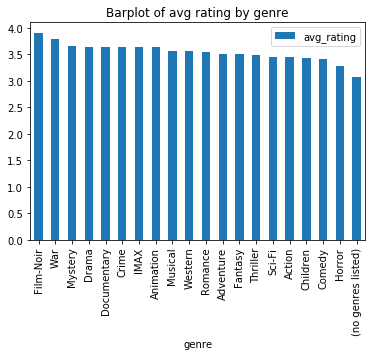

In [14]:
df.plot("genre", "avg_rating", "bar", title = "Barplot of avg rating by genre")